<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Projeto_modulo_3/rascunho_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando os dados

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from datetime import datetime
import statsmodels.tsa.stattools as smt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
casos_full = pd.read_csv("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/caso_full.csv.gz?raw=true", 
                         compression = "gzip")

casos_full.loc[:,"date"] = pd.to_datetime(casos_full.loc[:,"date"], format = "%Y-%m-%d")

casos_full = casos_full[casos_full.date != "2021-07-01"]

casos_full.loc[casos_full.loc[:,'new_confirmed'] < 0, 'new_confirmed'] = 0
casos_full.loc[casos_full.loc[:,'new_deaths'] < 0, 'new_deaths'] = 0

casos_full.describe()

,city_ibge_code,epidemiological_week,estimated_population,estimated_population_2019,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths
count,2.328812e+06,2.337328e+06,2.328812e+06,2.328812e+06,2.337328e+06,2.313292e+06,2.337328e+06,2.337328e+06,2.337328e+06,2.337328e+06,2.337328e+06
mean,3.222108e+06,2.020694e+05,8.473215e+04,8.408497e+04,2.750290e+03,3.272230e+03,2.825287e-02,7.557468e+01,2.096757e+02,1.599600e+01,4.469689e-01
std,1.010438e+06,3.919785e+01,9.323562e+05,9.256197e+05,3.539047e+04,3.467807e+03,6.263978e-02,1.110113e+03,1.219554e+02,2.200416e+02,7.359828e+00
min,1.100000e+01,2.020090e+05,7.760000e+02,7.810000e+02,0.000000e+00,2.160000e-03,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.508208e+06,2.020340e+05,5.683000e+03,5.684000e+03,5.800000e+01,7.002835e+02,7.700000e-03,1.000000e+00,1.050000e+02,0.000000e+00,0.000000e+00
50%,3.143807e+06,2.020490e+05,1.240200e+04,1.237100e+04,2.380000e+02,2.211856e+03,1.820000e-02,5.000000e+00,2.090000e+02,0.000000e+00,0.000000e+00
75%,4.116703e+06,2.021110e+05,2.751200e+04,2.728400e+04,7.700000e+02,4.767357e+03,3.060000e-02,1.600000e+01,3.130000e+02,3.000000e+00,0.000000e+00
max,5.300108e+06,2.021260e+05,4.628933e+07,4.591905e+07,3.727348e+06,9.048099e+05,1.000000e+00,1.276810e+05,4.920000e+02,4.502000e+04,1.389000e+03


In [3]:
feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2020 = pd.DataFrame({
    "holiday" : "sp_novos",
    "ds" : pd.to_datetime(feriados_sp_2020)
})

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]

feriados_sp_2021 = pd.DataFrame({
  'holiday': 'sp_2021',
  'ds': pd.to_datetime(feriados_sp_2021)
})

feriados = pd.concat((feriados_sp_2020, feriados_sp_2021))

In [4]:
vac_estado = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/20210630_evolucao_aplicacao_doses.csv",
                              sep = ";")

vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de janeiro de ", "/01/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de fevereiro de ", "/02/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de março de ", "/03/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de abril de ", "/04/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de maio de ", "/05/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de junho de ", "/06/")

vac_estado.iloc[:,0] = pd.to_datetime(vac_estado.iloc[:,0], format = "%d/%m/%Y")

vac_estado = vac_estado.rename(columns = {"Dia de Data Registro Vacina": "date"})

In [5]:
vac_sp = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/sao_paulo.xlsx?raw=true")
vac_sp = vac_sp[:-1]

vac_osa = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/osasco.xlsx?raw=true")
vac_osa = vac_osa[:-1]

vac_gru = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/guarulhos.xlsx?raw=true")
vac_gru = vac_gru[:-1]

vac_sbc = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/sbc.xlsx?raw=true")
vac_sbc = vac_sbc[:-1]

vac_fm = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/francisco_morato.xlsx?raw=true")
vac_fm = vac_fm[:-1]

vac_tab = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/taboao.xlsx?raw=true")
vac_tab = vac_tab[:-1]

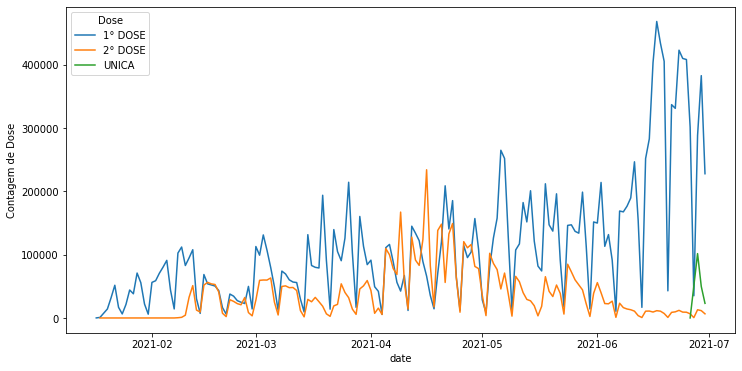

In [6]:
plt.figure(figsize=(12,6))

sns.lineplot(data = vac_estado, x = "date", y = "Contagem de Dose", hue = "Dose")

In [7]:
doses_soma = vac_estado.groupby("date").sum().reset_index()

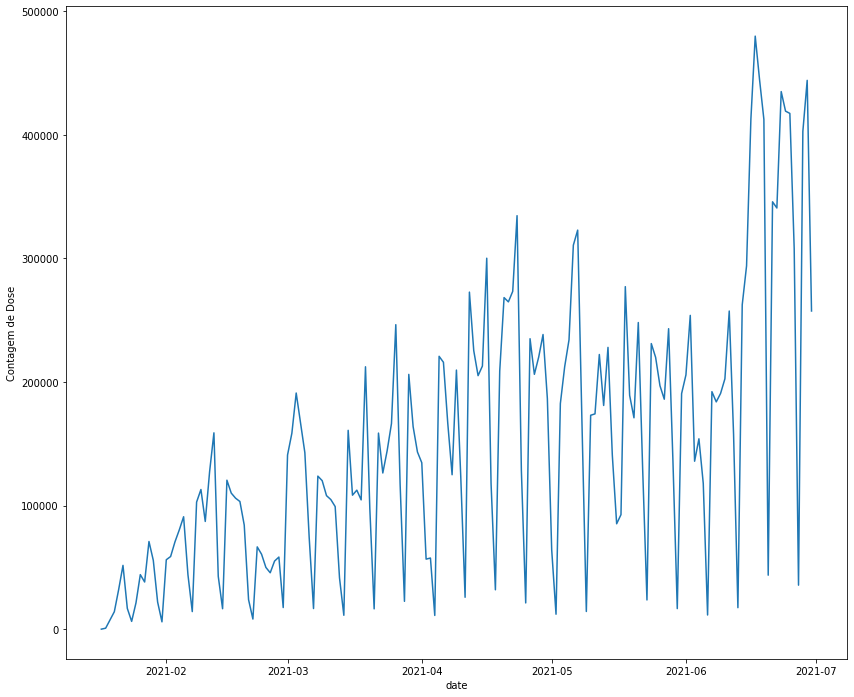

In [8]:
plt.figure(figsize = (14,12))
sns.lineplot(data = doses_soma, x = "date", y = "Contagem de Dose")

In [9]:
df_doses = pd.DataFrame()

df_doses.loc[:,"ds"] = doses_soma.loc[:,"date"] # esse aporte de novas vacinas foi muito importante para retomar a aceleração!
df_doses.loc[:,"y"] = doses_soma.loc[:,"Contagem de Dose"]

df_doses_teste = pd.DataFrame()

df_doses_teste.loc[:,"ds"] = doses_soma.loc[:,"date"][149:]
df_doses_teste.loc[:,"y"] = doses_soma.loc[:,"Contagem de Dose"][149:]

df_doses

,ds,y
0,2021-01-17,100
1,2021-01-18,879
2,2021-01-19,7451
3,2021-01-20,14193
4,2021-01-21,32109
...,...,...
160,2021-06-26,307998
161,2021-06-27,35674
162,2021-06-28,402763
163,2021-06-29,444026


In [10]:
doses_soma.loc[:,"soma"] = doses_soma.loc[:,"Contagem de Dose"].cumsum()
doses_soma

,date,Contagem de Dose,soma
0,2021-01-17,100,100
1,2021-01-18,879,979
2,2021-01-19,7451,8430
3,2021-01-20,14193,22623
4,2021-01-21,32109,54732
...,...,...,...
160,2021-06-26,307998,23447232
161,2021-06-27,35674,23482906
162,2021-06-28,402763,23885669
163,2021-06-29,444026,24329695


In [11]:
df_doses_soma = pd.DataFrame()

df_doses_soma.loc[:,"ds"] = doses_soma.loc[:,"date"] # esse aporte de novas vacinas foi muito importante para retomar a aceleração!
df_doses_soma.loc[:,"y"] = doses_soma.loc[:,"soma"]

df_doses_soma_teste = pd.DataFrame()

df_doses_soma_teste.loc[:,"ds"] = doses_soma.loc[:,"date"][149:]
df_doses_soma_teste.loc[:,"y"] = doses_soma.loc[:,"soma"][149:]

df_doses_soma

,ds,y
0,2021-01-17,100
1,2021-01-18,979
2,2021-01-19,8430
3,2021-01-20,22623
4,2021-01-21,54732
...,...,...
160,2021-06-26,23447232
161,2021-06-27,23482906
162,2021-06-28,23885669
163,2021-06-29,24329695


In [12]:
# m7 = Prophet(growth = "logistic", changepoint_prior_scale = 0.1)

# m7.fit(df_doses_soma)
# df_prev7 = m7.make_future_dataframe(periods = 365)
# df_prev7.loc[:,"cap"] = [pop_sp*2] * (165 + 365)

# prev7 = m7.predict(df_prev7)

# m7.plot(prev7, figsize = (20,10));
# # plt.plot(df_doses_teste.loc[:,"ds"], df_doses_teste.loc[:,"y"], "r.")

# Dinamicas nas cidades pendulo

(dá trabalho mas fica mais organizado)

In [13]:
df_sp = casos_full.query("city == 'São Paulo'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_sp.loc[:,"ma_cases"] = df_sp.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_sp.loc[:,"ma_deaths"] = df_sp.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_osa = casos_full.query("city == 'Osasco'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_osa.loc[:,"ma_cases"] = df_osa.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_osa.loc[:,"ma_deaths"] = df_osa.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_gru = casos_full.query("city == 'Guarulhos'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_gru.loc[:,"ma_cases"] = df_gru.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_gru.loc[:,"ma_deaths"] = df_gru.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_sbc = casos_full.query("city == 'São Bernardo do Campo'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_sbc.loc[:,"ma_cases"] = df_sbc.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_sbc.loc[:,"ma_deaths"] = df_sbc.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_fm = casos_full.query("city == 'Francisco Morato'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_fm.loc[:,"ma_cases"] = df_fm.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_fm.loc[:,"ma_deaths"] = df_fm.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_tab = casos_full.query("city == 'Taboão da Serra'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_tab.loc[:,"ma_cases"] = df_tab.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_tab.loc[:,"ma_deaths"] = df_tab.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

In [14]:
df_cities = pd.concat([df_sp, df_osa, df_gru, df_sbc, df_fm, df_tab],
                  axis = 0, join = 'inner', keys = ["São Paulo","Osasco","Guarulhos",
                                                    "São Bernando do Campo", "Francisco Morato",
                                                    "Taboão da Serra"]).reset_index()

df_cities.drop("level_1", axis = 1, inplace = True)

df_cities.rename(columns = {'level_0':'cidade'}, inplace=True)

df_cities.describe()

,new_confirmed,new_deaths,last_available_confirmed,last_available_deaths,estimated_population,ma_cases,ma_deaths
count,2823.000000,2823.000000,2823.000000,2823.000000,2.823000e+03,2787.000000,2787.000000
mean,371.134963,15.695714,73465.161530,3098.311371,2.714862e+06,373.582603,15.763237
std,884.986528,37.517318,164159.159194,6306.938326,4.433438e+06,746.838917,30.891427
min,0.000000,0.000000,1.000000,0.000000,1.776330e+05,0.000000,0.000000
25%,18.000000,0.000000,3880.500000,179.000000,2.936520e+05,32.500000,1.285714
50%,63.000000,3.000000,14328.000000,761.000000,8.444830e+05,78.857143,3.857143
75%,194.000000,11.000000,36693.500000,1883.000000,1.392121e+06,175.785714,11.071429
max,8646.000000,378.000000,855163.000000,33510.000000,1.232523e+07,4706.285714,226.000000


## Casos

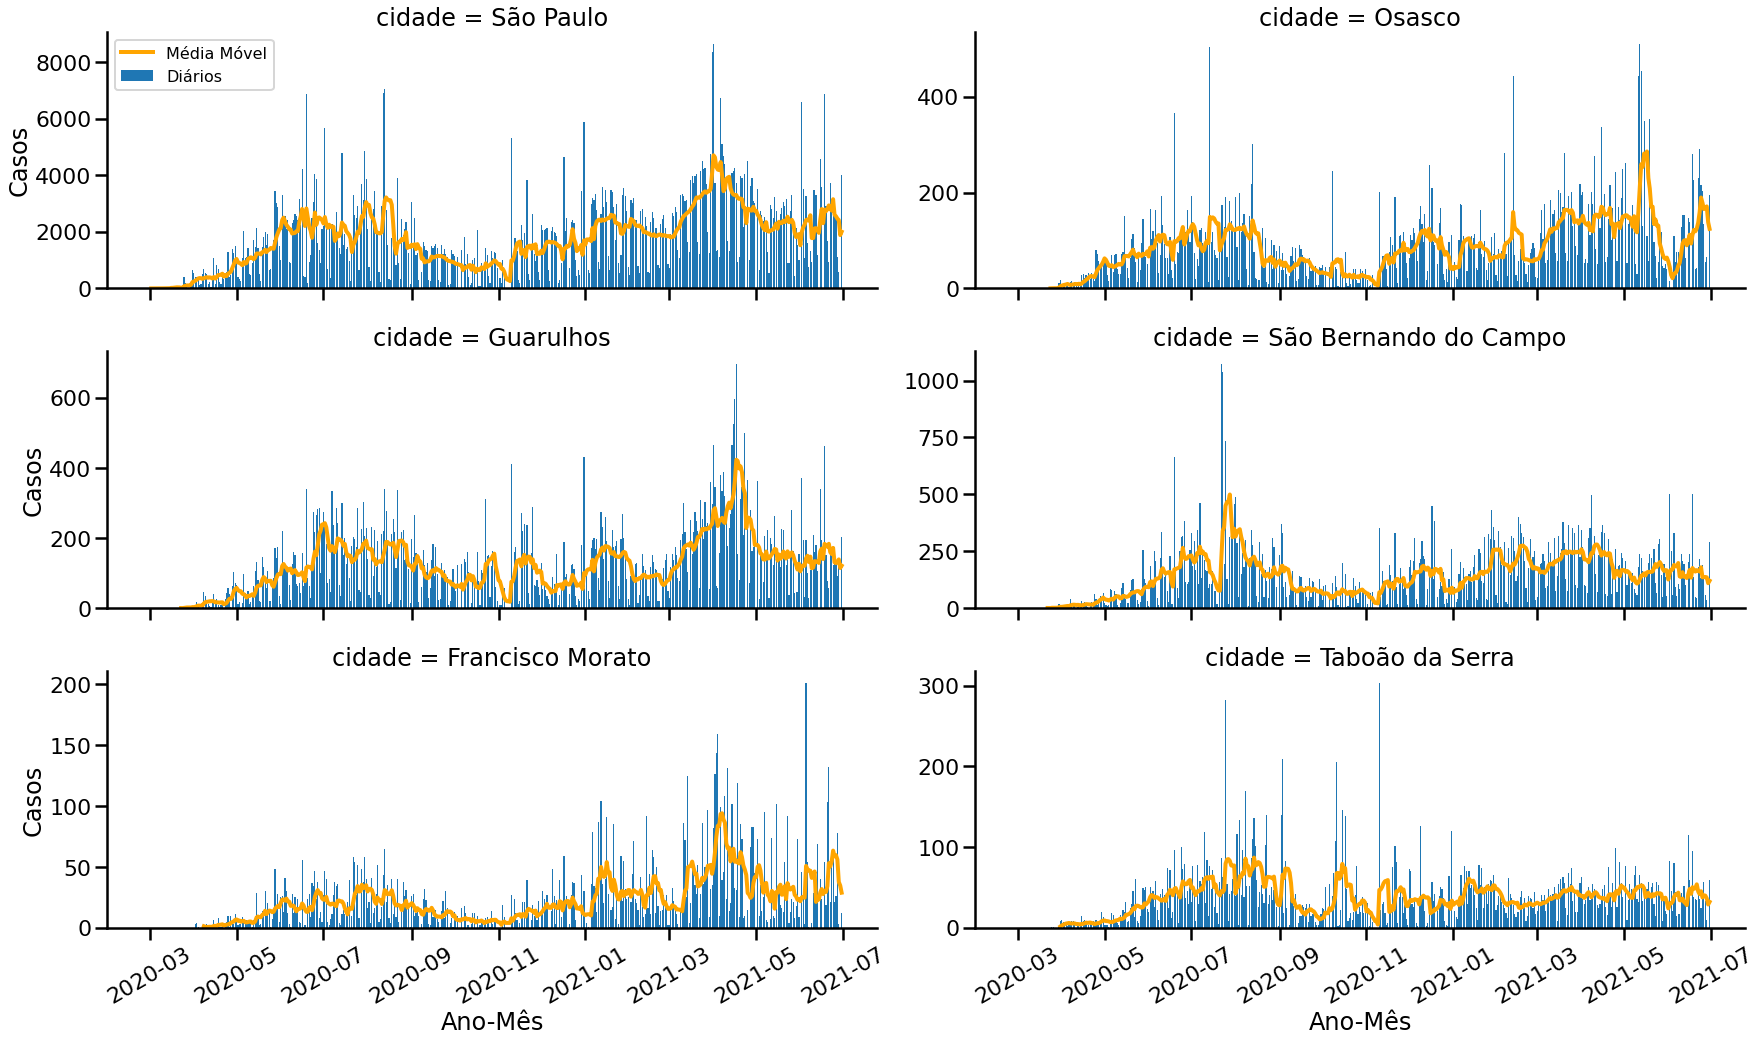

In [15]:
sns.set_context("poster")
g = sns.FacetGrid(data = df_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.5)
g.map_dataframe(plt.bar, x = "date", height = "new_confirmed", label = "Diários")
g.map_dataframe(sns.lineplot, x = "date", y = "ma_cases", linewidth = 4, label = "Média Móvel", color = "orange")
g.set_xticklabels(rotation = 30)
g.set_axis_labels("Ano-Mês", "Casos")
g.axes[0].legend(fontsize = 16, loc = "upper left")
plt.tight_layout()
plt.show()

## Mortes

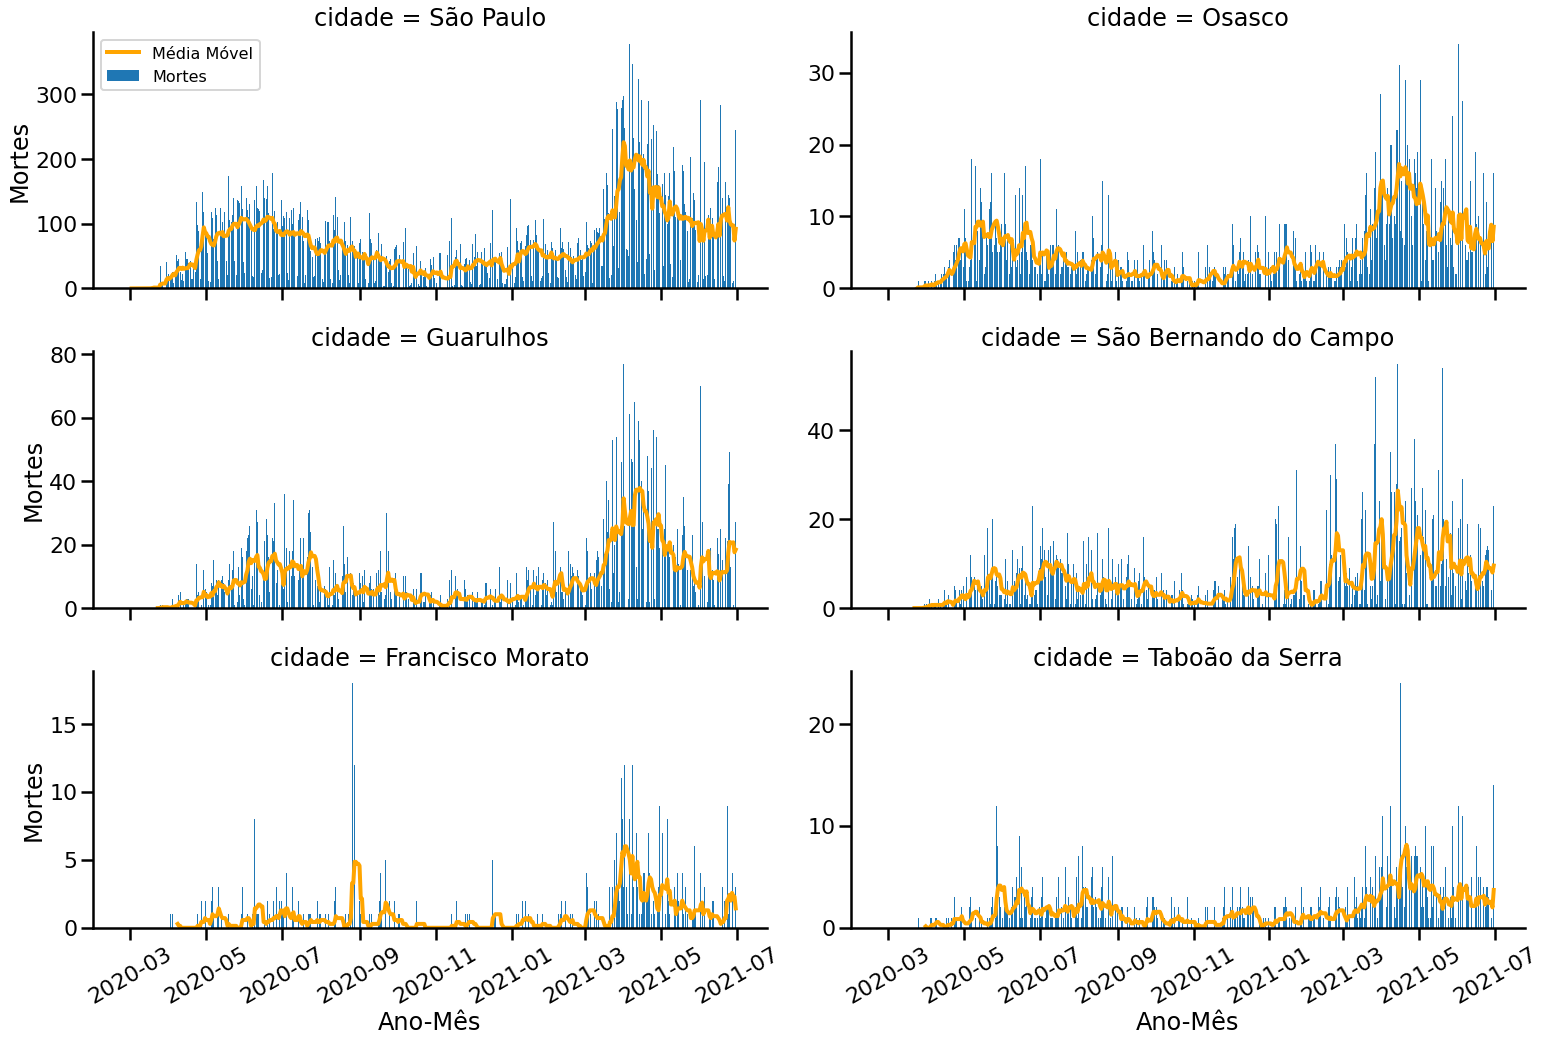

In [16]:
sns.set_context("poster")
g = sns.FacetGrid(data = df_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.2)
g.map_dataframe(plt.bar, x = "date", height = "new_deaths", label = "Mortes")
g.map_dataframe(sns.lineplot, x = "date", y = "ma_deaths", linewidth = 4, label = "Média Móvel", color = "orange")
g.set_axis_labels("Ano-Mês", "Mortes")
g.set_xticklabels(rotation = 30)
g.axes[0].legend(fontsize = 16, loc = "upper left")
plt.tight_layout()
plt.show()

In [17]:
sns.set_context("talk")

## Analise de correlação

### Casos

In [18]:
sp_osa = smt.ccf(df_sp.loc[:,"new_confirmed"], df_osa.loc[:,"new_confirmed"], unbiased = False)
sp_osa_lag = range(0, len(df_osa))

sp_gru = smt.ccf(df_sp.loc[:,"new_confirmed"], df_gru.loc[:,"new_confirmed"], unbiased = False)
sp_gru_lag = range(0, len(df_gru))

sp_sbc = smt.ccf(df_sp.loc[:,"new_confirmed"], df_sbc.loc[:,"new_confirmed"], unbiased = False)
sp_sbc_lag = range(0, len(df_sbc))

sp_fm = smt.ccf(df_sp.loc[:,"new_confirmed"], df_fm.loc[:,"new_confirmed"], unbiased = False)
sp_fm_lag = range(0, len(df_fm))

sp_tab = smt.ccf(df_sp.loc[:,"new_confirmed"], df_tab.loc[:,"new_confirmed"], unbiased = False)
sp_tab_lag = range(0, len(df_tab))

In [19]:
corrs = [sp_osa, sp_gru, sp_sbc, sp_fm, sp_tab]
corr_lags = [sp_osa_lag, sp_gru_lag, sp_sbc_lag, sp_fm_lag, sp_tab_lag]
cidades = ["Osasco", "Guarulhos", "São Bernardo do Campo", "Francisco Morato", "Taboão da Serra"]

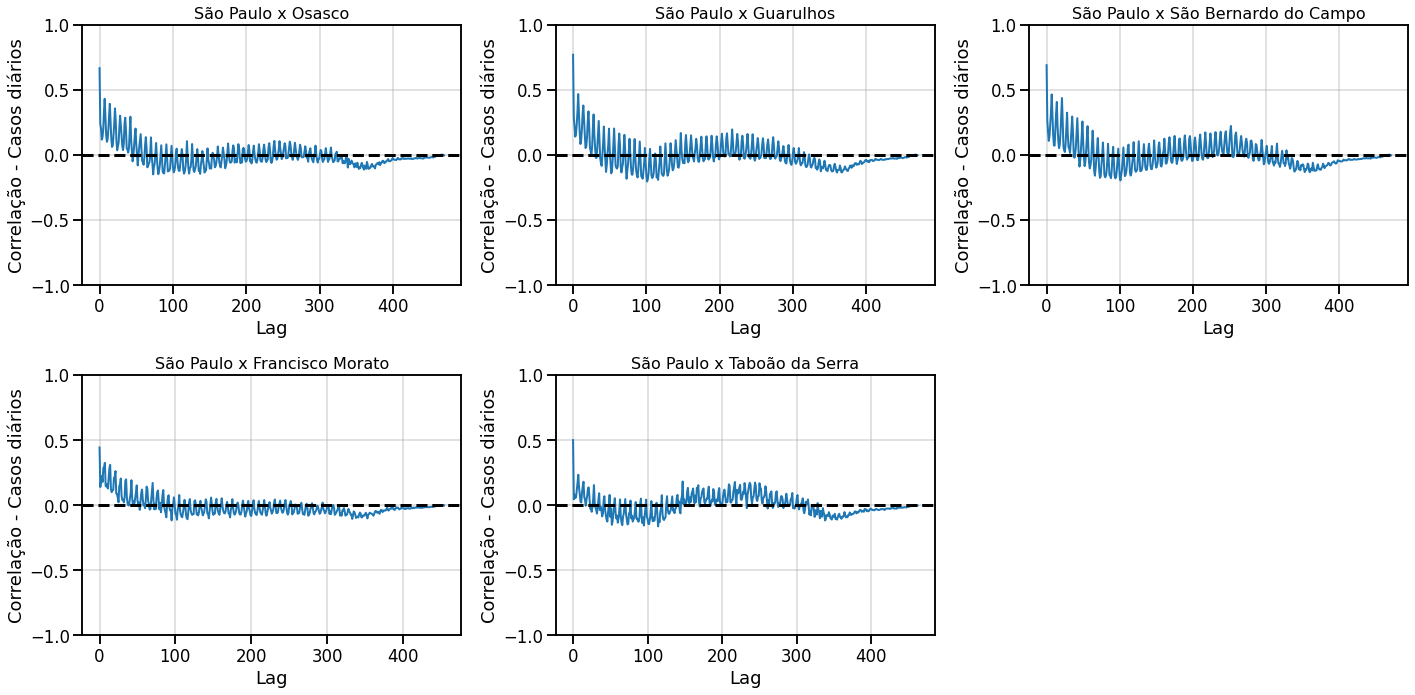

In [20]:
fig = plt.figure(figsize = (20, 10))

for k in range(1,6):
  fig.add_subplot(2, 3, k)
  plt.title("São Paulo x " + cidades[k -1], fontsize = 16)
  plt.plot(corr_lags[k - 1], corrs[k - 1], lw = 2)
  plt.ylim(-1,1)
  plt.xlabel("Lag")
  plt.ylabel("Correlação - Casos diários")
  plt.grid(alpha = .5)
  plt.axhline(y = 0, color = "black", lw = 3, ls = "--")
 
plt.tight_layout()
plt.show()

### Mortes

In [21]:
sp_osa = smt.ccf(df_sp.loc[:,"new_deaths"], df_osa.loc[:,"new_deaths"], unbiased = False)
sp_osa_lag = range(0, len(df_osa))

sp_gru = smt.ccf(df_sp.loc[:,"new_deaths"], df_gru.loc[:,"new_deaths"], unbiased = False)
sp_gru_lag = range(0, len(df_gru))

sp_sbc = smt.ccf(df_sp.loc[:,"new_deaths"], df_sbc.loc[:,"new_deaths"], unbiased = False)
sp_sbc_lag = range(0, len(df_sbc))

sp_fm = smt.ccf(df_sp.loc[:,"new_deaths"], df_fm.loc[:,"new_deaths"], unbiased = False)
sp_fm_lag = range(0, len(df_fm))

sp_tab = smt.ccf(df_sp.loc[:,"new_deaths"], df_tab.loc[:,"new_deaths"], unbiased = False)
sp_tab_lag = range(0, len(df_tab))

In [22]:
corrs = [sp_osa, sp_gru, sp_sbc, sp_fm, sp_tab]
corr_lags = [sp_osa_lag, sp_gru_lag, sp_sbc_lag, sp_fm_lag, sp_tab_lag]
cidades = ["Osasco", "Guarulhos", "São Bernardo do Campo", "Francisco Morato", "Taboão da Serra"]

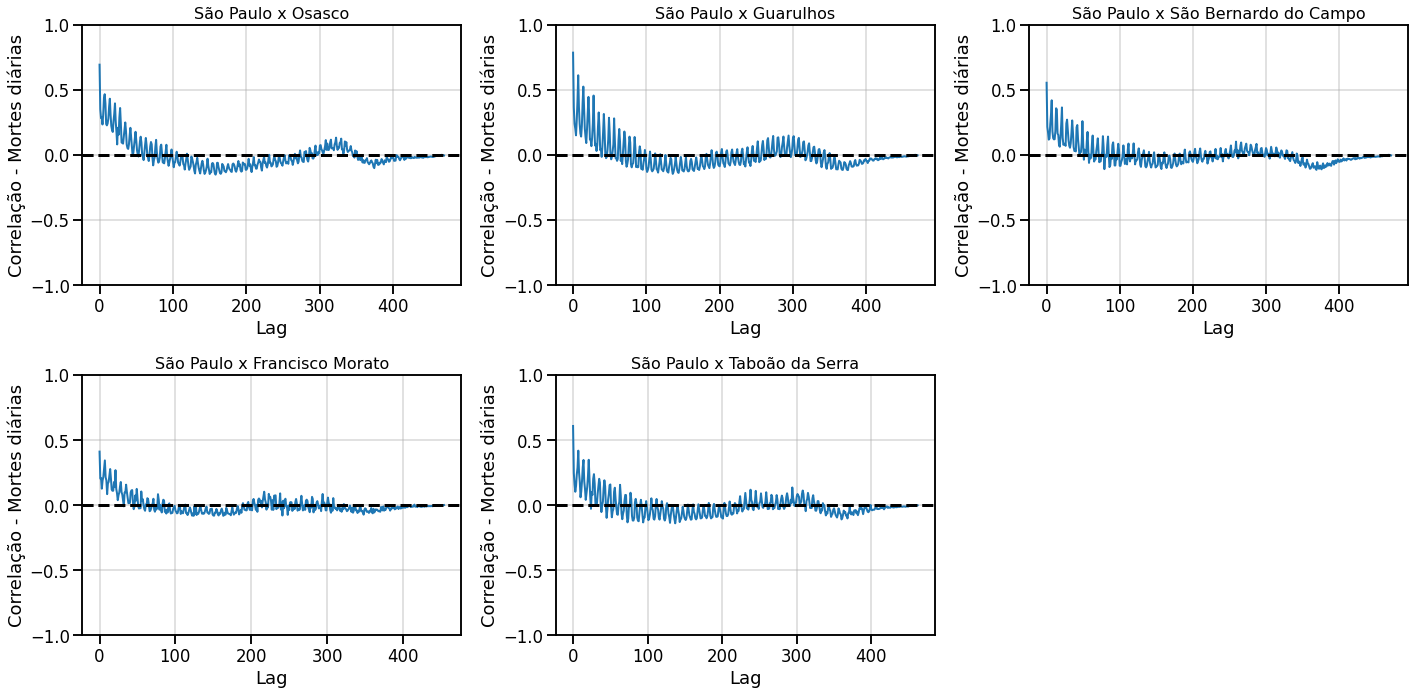

In [23]:
fig = plt.figure(figsize = (20, 10))

for k in range(1,6):
  fig.add_subplot(2, 3, k)
  plt.title("São Paulo x " + cidades[k -1], fontsize = 16)
  plt.plot(corr_lags[k - 1], corrs[k - 1], lw = 2)
  plt.ylim(-1,1)
  plt.xlabel("Lag")
  plt.ylabel("Correlação - Mortes diárias")
  plt.grid(alpha = .5)
  plt.axhline(y = 0, color = "black", lw = 3, ls = "--")

plt.tight_layout()
plt.show()

# Vacinação

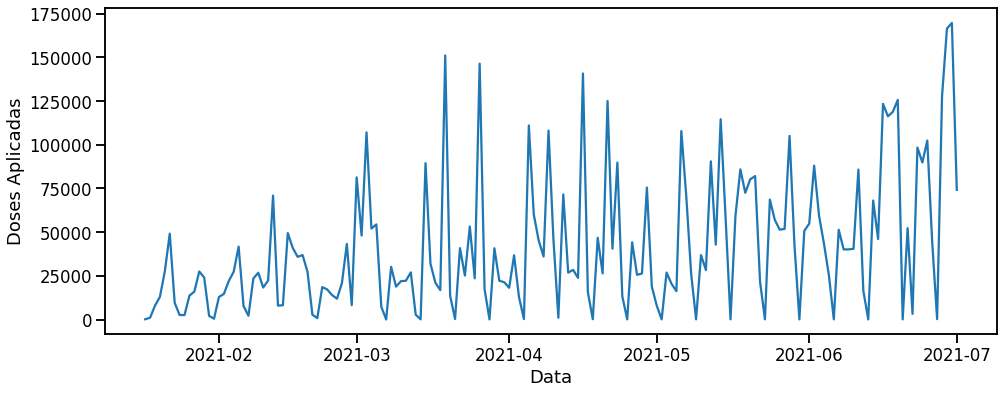

In [24]:
plt.figure(figsize = (16, 6))
sns.lineplot(data = vac_sp, x = "Data", y = "Doses Aplicadas")

# Estado

# Cidades

## Taxas diárias

## Cumulativo

# Previsões

## Taxas diarias

## Cumulativo